In [301]:
import anndata
import pandas as pd
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from scipy.stats import zscore

import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from matplotlib import colors

%load_ext jupyter_black

# Read protein map
protein_map = pd.read_csv(
    "2022_11_16_Protein-Gene mapping_markers for data integration_edited.csv"
)

# Remove non-relevant antigens
protein_map = protein_map[protein_map["Comment"].isnull()]
# Remove whitespace from marker names
protein_map["Antigen (CODEX)"] = protein_map["Antigen (CODEX)"].str.strip()
protein_map["Gene"] = protein_map["Gene"].str.strip()

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [302]:
obs_columns = [
    "Unnamed: 0",
    "X",
    "index",
    "Object.Id",
    "XMin",
    "XMax",
    "YMin",
    "YMax",
    "Tissue",
    "Patient",
    "Celltype",
    "Class",
    "Class0",
]

marker_columns = [
    "CD56.Cytoplasm.Intensity",
    "CD161.Cytoplasm.Intensity",
    "TCRValpha.Cytoplasm.Intensity",
    "CD39.Cytoplasm.Intensity",
    "CD25.Cytoplasm.Intensity",
    "CD57.Cytoplasm.Intensity",
    "CD40.Cytoplasm.Intensity",
    "ICOS.Cytoplasm.Intensity",
    "CD3.Cytoplasm.Intensity",
    "CD62L.Cytoplasm.Intensity",
    "LYVE.1.Cytoplasm.Intensity",
    "CD45RO.Cytoplasm.Intensity",
    "IL18Ra.Cytoplasm.Intensity",
    "PD.L1.Cytoplasm.Intensity",
    "CD45.Cytoplasm.Intensity",
    "CD34.Cytoplasm.Intensity",
    "CD163.Cytoplasm.Intensity",
    "Ki67.Nucleus.Intensity",
    "CD19.Cytoplasm.Intensity",
    "CD38.Cytoplasm.Intensity",
    "CD279.Cytoplasm.Intensity",
    "CD11c.Cytoplasm.Intensity",
    "CD8.Cytoplasm.Intensity",
    "CD11b.Cytoplasm.Intensity",
    "CD16.Cytoplasm.Intensity",
    "FoxP3.Nucleus.Intensity",
    "CD69.Cytoplasm.Intensity",
    "CD15.Cytoplasm.Intensity",
    "HNFalpha.Nucleus.Intensity",
    "pancytokeratin.Cytoplasm.Intensity",
    "HLADR.Cytoplasm.Intensity",
    "CD45RA.Cytoplasm.Intensity",
    "aSMA.Cytoplasm.Intensity",
    "CD4.Cytoplasm.Intensity",
    "CD66b.Cytoplasm.Intensity",
    "CD68.Cytoplasm.Intensity",
    "EPCAM.Cytoplasm.Intensity",
]

markers = []
for column in marker_columns:
    if "Intensity" in column:
        markers.append("-".join(column.split(".")[:-2]))

In [303]:
# Read codex and scRNA-seq data
adata = anndata.read("CODEX_cd8_no_harmony.h5ad")
sc_adata = anndata.read("adata_CD8_velocity_all.h5ad")

/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [306]:
# Process the protein map into a dictionary with names matching adata var names
protein_map_dict = {}
for marker in markers:
    gene_aliases = protein_map[protein_map["Antigen (CODEX)"] == marker][
        "Gene"
    ].values.reshape(-1)
    protein_map_dict[marker] = []
    for gene_name in gene_aliases:
        split = gene_name.split(",")
        for name in split:
            protein_map_dict[marker].append(name.strip())

# Make a list of shared and highly variable markers
markers_to_keep = []
genes_to_keep = []
for key, values in protein_map_dict.items():
    for gene in values:  # in case a protein matches to more than one gene that protein gets repeated
        if (
            gene in sc_adata.var[sc_adata.var["highly_variable"]].index.values
        ):  # keep only higly variable genes
            genes_to_keep.append(gene)
            markers_to_keep.append(key)  

In [307]:
# Subset to only shared markers
adata.var_names = markers
adata_compare = adata[:, markers_to_keep]
# Only keep cells with PD1-high or -low labels
adata_compare = adata_compare[adata_compare.obs["Class0"] != "T cells CD8 PD-L1+"]

sc_adata_compare = sc_adata[:, genes_to_keep]
sc_adata_compare.shape

<Axes: >

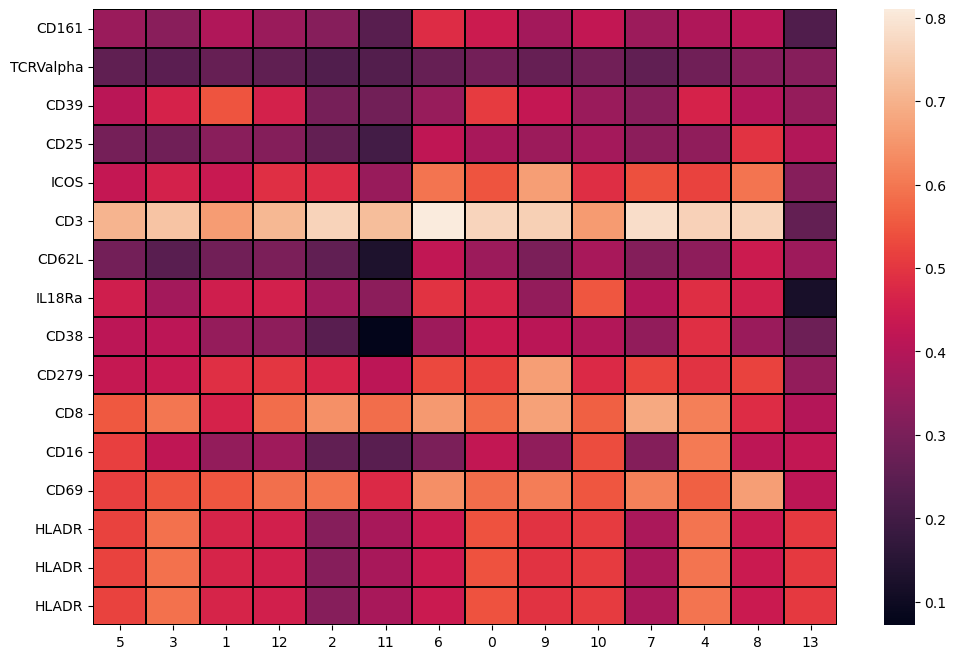

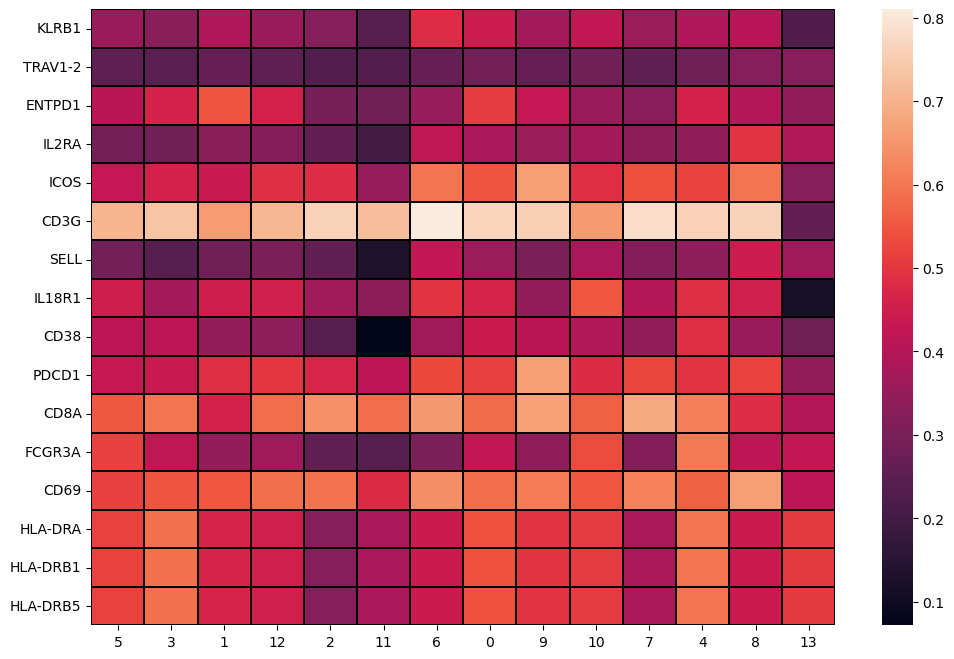

In [309]:
# Compute mean CODEX expressions
mean_expressions = []
clusters = []
for leiden_cluster in adata_compare.obs["leiden"].unique():
    cells = adata_compare[adata_compare.obs["leiden"] == leiden_cluster]
    mean_expressions.append(cells.X.mean(axis=0))
    clusters.append(leiden_cluster)
mean_expressions = np.array(mean_expressions)

plt.figure(figsize=(12, 8))
sns.heatmap(
    mean_expressions.T,
    xticklabels=clusters,
    yticklabels=adata_compare.var_names,
    linewidth=0.1,
    linecolor="k",
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    mean_expressions.T,
    xticklabels=clusters,
    yticklabels=genes_to_keep,
    linewidth=0.1,
    linecolor="k",
)

<Axes: >

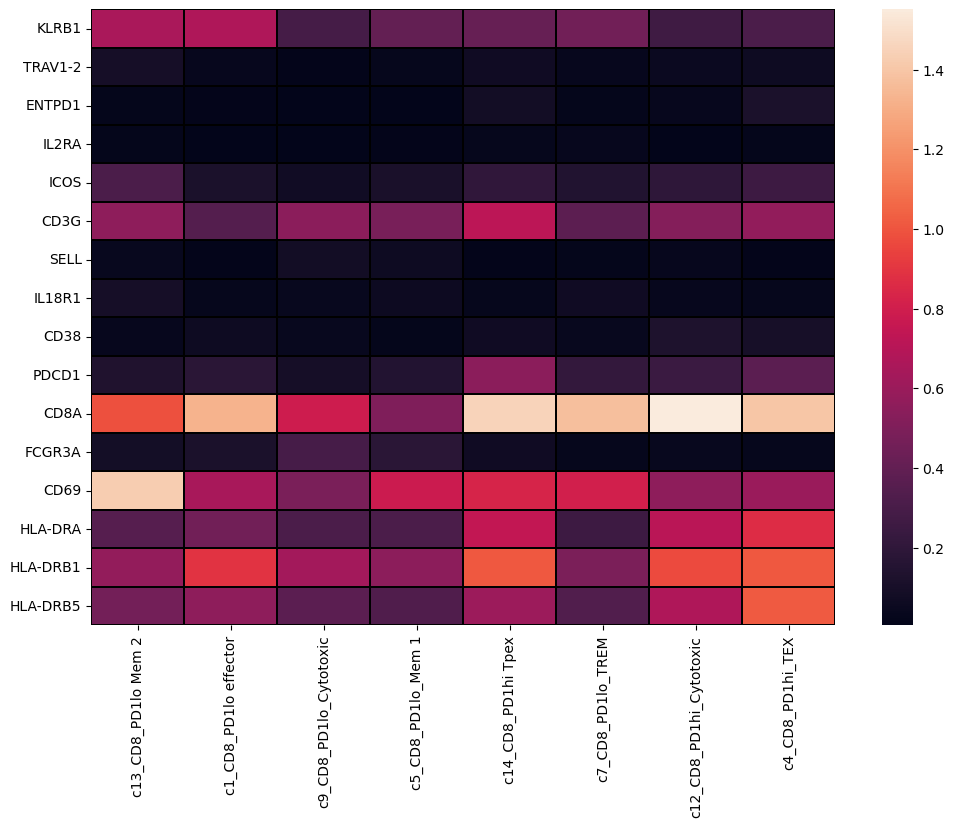

In [310]:
# Compute mean scRNA-seq expressions
mean_expressions_sc = []
clusters_sc = []
for leiden_cluster in sc_adata_compare.obs["Cluster label"].unique():
    cells = sc_adata_compare[sc_adata_compare.obs["Cluster label"] == leiden_cluster]
    mean_expressions_sc.append(cells.X.mean(axis=0))
    clusters_sc.append(leiden_cluster)
mean_expressions_sc = np.stack(mean_expressions_sc, axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(
    mean_expressions_sc.T,
    xticklabels=clusters_sc,
    yticklabels=sc_adata_compare.var_names,
    linewidth=0.1,
    linecolor="k",
)

In [312]:
# Compute correlations
mean_expressions_sc = np.asarray(mean_expressions_sc)
mean_expressions = np.asarray(mean_expressions)

dist_x_corr = pairwise_distances(
    X=mean_expressions_sc, Y=mean_expressions, metric="correlation"
)
dist_x_corr = -dist_x_corr + 1

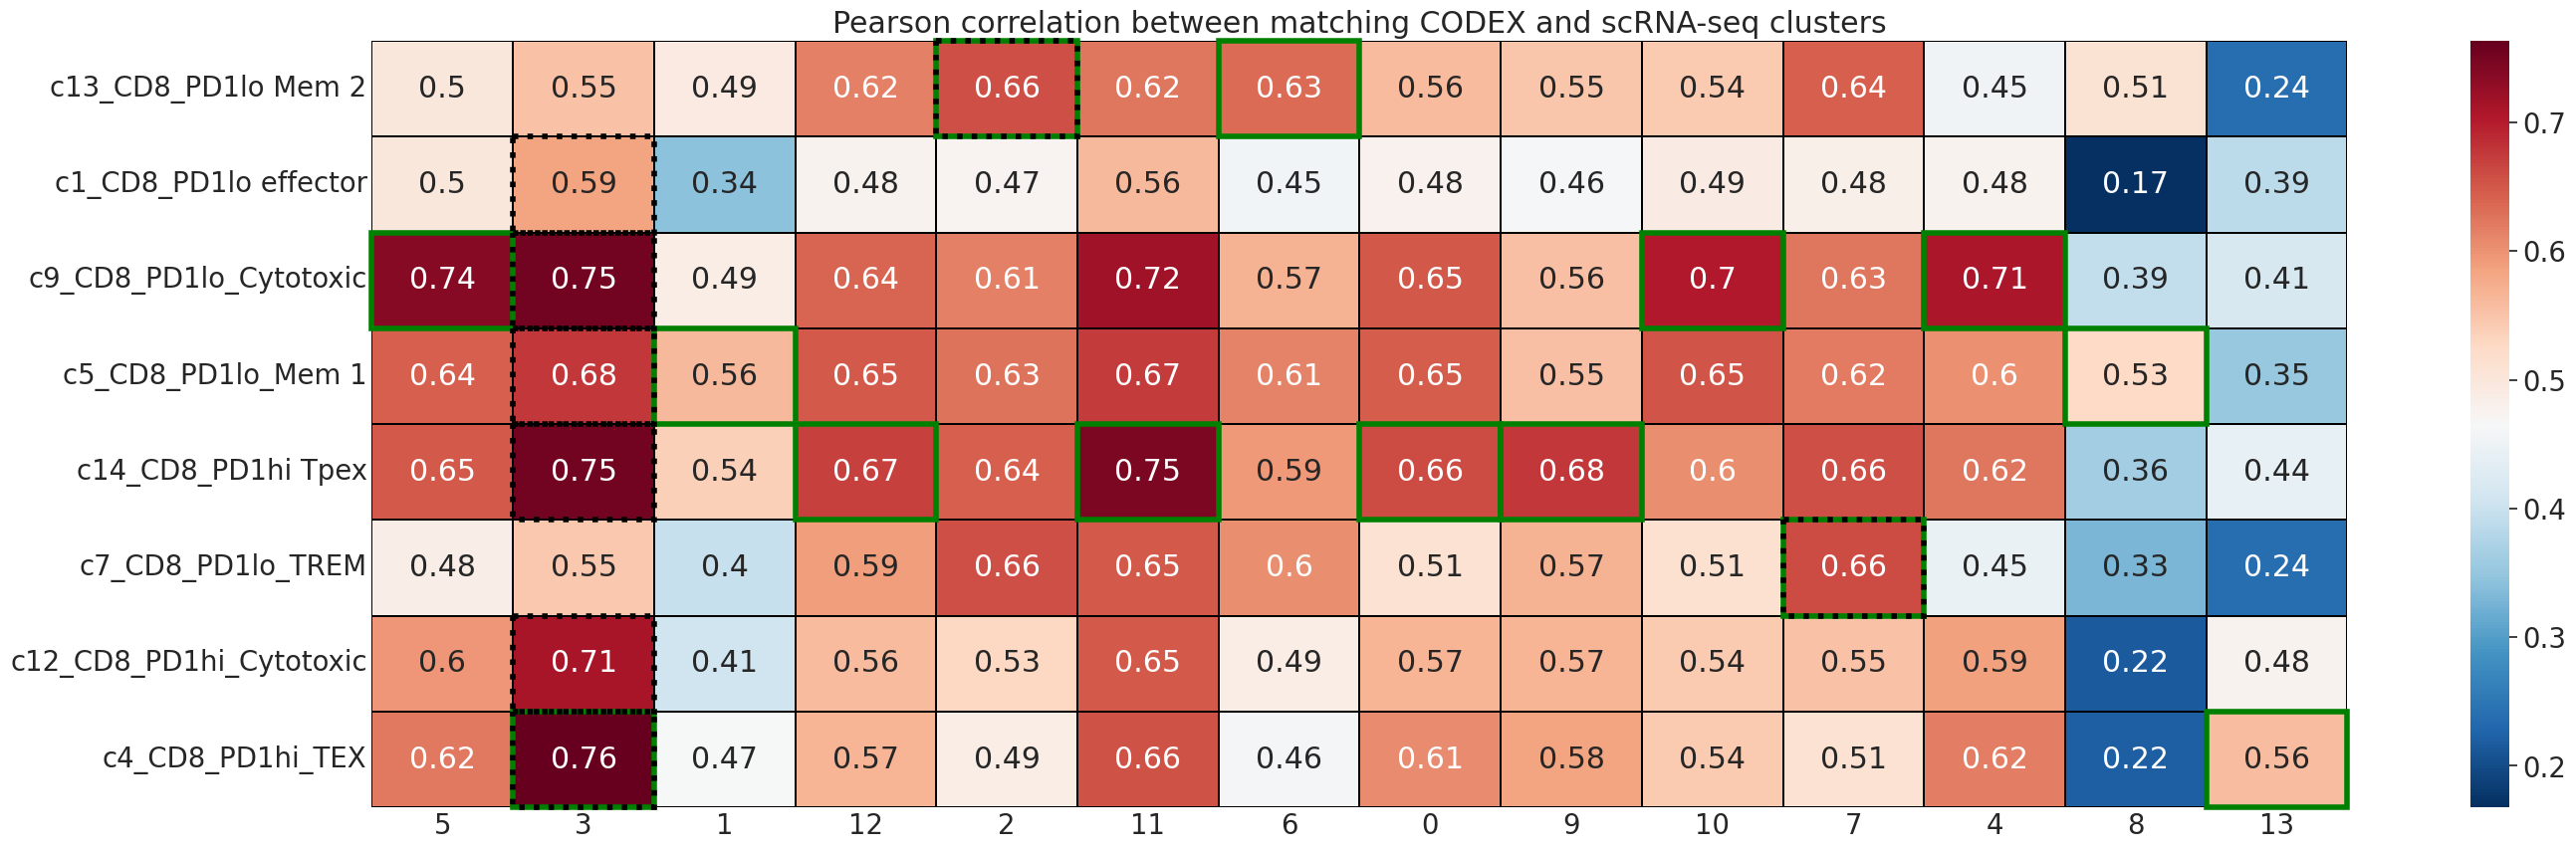

In [317]:
from matplotlib.patches import Rectangle

dist_x_corr_to_keep = dist_x_corr[:, indices]
sns.set(font_scale=1.8)
plt.figure(figsize=(32, 10))
ax = sns.heatmap(
    dist_x_corr_to_keep,
    annot=True,
    linewidths=0.2,
    linecolor="black",
    cmap="RdBu_r",
    xticklabels=np.array(clusters)[indices],
    yticklabels=np.array(clusters_sc),
)

cluster_match_dict = {}

# Highlight max correlation per column  (CODEX to scRNA-seq)
for cluster in range(dist_x_corr_to_keep.shape[1]):

    cluster_sc = np.argmax(dist_x_corr_to_keep[:, cluster]).item()

    x, y, w, h = cluster, cluster_sc, 1, 1

    cluster_match_dict[np.array(clusters)[indices][cluster]] = clusters_sc[cluster_sc]

    ax.add_patch(
        Rectangle((x, y), w, h, fill=False, edgecolor="green", lw=4, clip_on=False)
    )

    ax.tick_params(length=0)

# Highlight max correlation per row (scRNA-seq to CODEX)
for cluster in range(dist_x_corr_to_keep.shape[0]):

    cluster_codex = np.argmax(dist_x_corr_to_keep[cluster, :]).item()

    x, y, w, h = cluster_codex, cluster, 1, 1

    ax.add_patch(
        Rectangle(
            (x, y),
            w,
            h,
            fill=False,
            edgecolor="black",
            lw=4,
            clip_on=False,
            linestyle="dotted",
        )
    )

    ax.tick_params(length=0)

plt.title(r"Pearson correlation between matching CODEX and scRNA-seq clusters")
plt.show()

In [291]:
# Transfer labels
adata_compare.obs["Cluster label"] = pd.NA

for key, value in cluster_match_dict.items():
    indices = adata_compare.obs["leiden"] == key
    adata_compare.obs.loc[indices, "Cluster label"] = value

/tmp/ipykernel_576259/2705857699.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_compare.obs["Cluster label"] = pd.NA
/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Accuracy: 0.5434916096596851
F1-high: 0.3023029041079821
F1-low: 0.6607632390424755
F1-avg: 0.4815330715752288
              precision    recall  f1-score   support

    PD1-high       0.34      0.28      0.30     74908
     PD1-low       0.63      0.69      0.66    133546

    accuracy                           0.54    208454
   macro avg       0.48      0.48      0.48    208454
weighted avg       0.52      0.54      0.53    208454



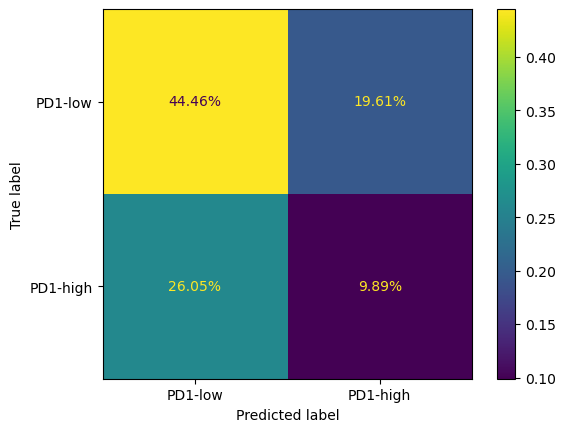

In [292]:
## Compute accuarcy
adata_labeled = adata_compare[adata_compare.obs["Cluster label"].notnull()]

predicted_pd1_levels = ["PD1hi" in x for x in adata_labeled.obs["Cluster label"]]
predicted_pd1_levels = ["PD1-high" if x else "PD1-low" for x in predicted_pd1_levels]
true_pd1_levels = adata_labeled.obs["Class0"] == "T cells CD8 PD-1high"
true_pd1_levels = ["PD1-high" if x else "PD1-low" for x in true_pd1_levels]


accuracy = accuracy_score(true_pd1_levels, predicted_pd1_levels)
f1_hi = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-high")
f1_low = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-low")

print("Accuracy:", accuracy)
print("F1-high:", f1_hi)
print("F1-low:", f1_low)
print("F1-avg:", (f1_low + f1_hi) / 2)

labels = ["PD1-low", "PD1-high"]

print(classification_report(true_pd1_levels, predicted_pd1_levels))

cm = confusion_matrix(true_pd1_levels, predicted_pd1_levels, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm / np.sum(cm), display_labels=labels)
disp.plot(values_format=".2%")

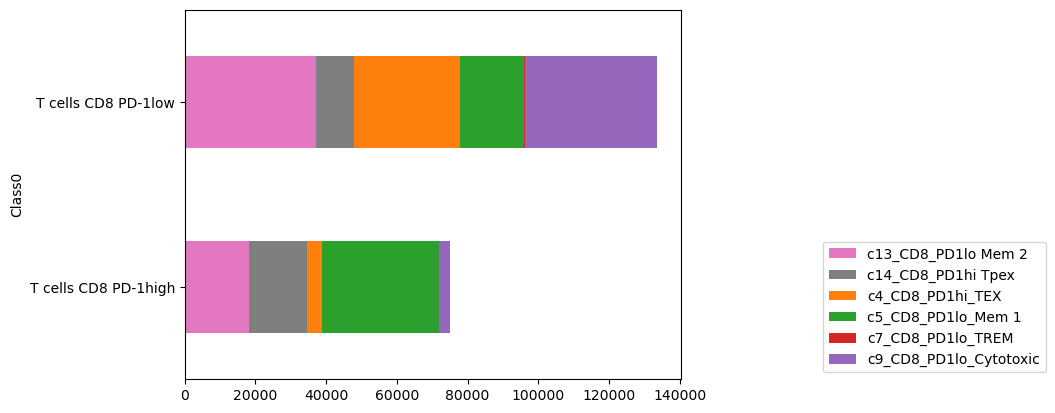

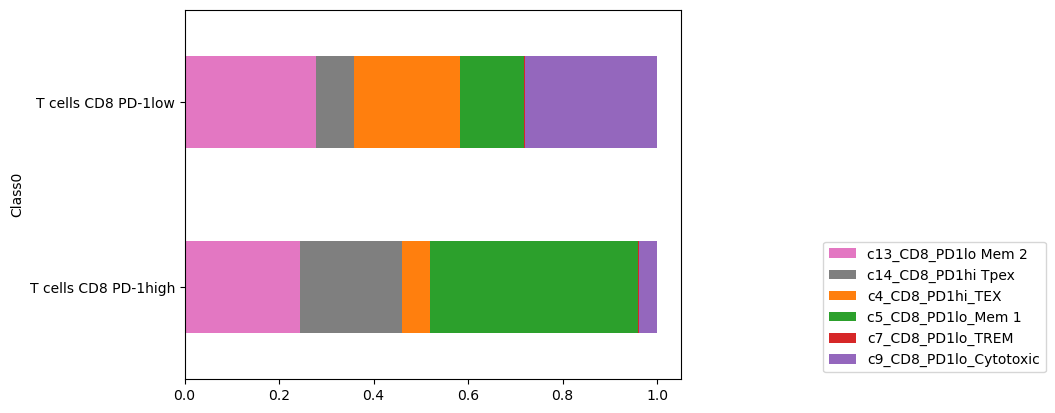

In [293]:
# Plot transferred label counts separated by CODEX label
count_df_ = (
    adata_compare.obs.value_counts(["Class0", "Cluster label"])
    .reset_index()
    .pivot(index="Class0", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True, color=color_dict)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True, color=color_dict)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

# Scanpy ingest

In [233]:
sc_adata_ref = sc_adata_compare.copy()

In [238]:
scp.pp.pca(sc_adata_ref)
scp.external.pp.harmony_integrate(sc_adata_ref, key="Patient", max_iter_harmony=20)
scp.pp.neighbors(sc_adata_ref, n_neighbors=30, use_rep="X_pca_harmony")
scp.tl.umap(sc_adata_ref, random_state=0, min_dist=0.5, spread=1)
sc_adata_ref.obsm["X_pca"] = sc_adata_ref.obsm[
    "X_pca_harmony"
]  # use batch integrated pca

2025-09-22 09:50:26,804 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-09-22 09:50:28,342 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-09-22 09:50:28,381 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2025-09-22 09:50:30,463 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2025-09-22 09:50:32,530 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2025-09-22 09:50:34,577 - harmonypy - INFO - Iteration 4 of 20
INFO:harmonypy:Iteration 4 of 20
2025-09-22 09:50:36,712 - harmonypy - INFO - Iteration 5 of 20
INFO:harmonypy:Iteration 5 of 20
2025-09-22 09:50:38,780 - harmonypy - INFO - Iteration 6 of 20
INFO:harmonypy:Iteration 6 of 20
2025-09-22 09:50:40,161 - harmonypy - INFO - Iteration 7 of 20
INFO:harmonypy:Iteration 7 of 20
2025-09-22 09:50:41,243 - 

/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


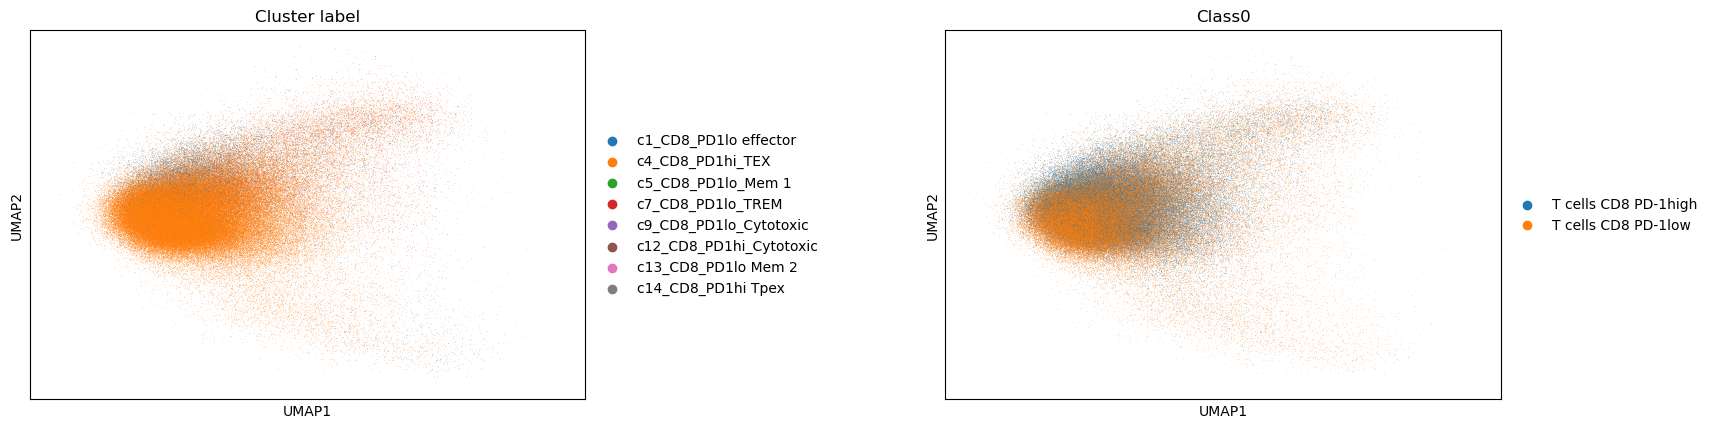

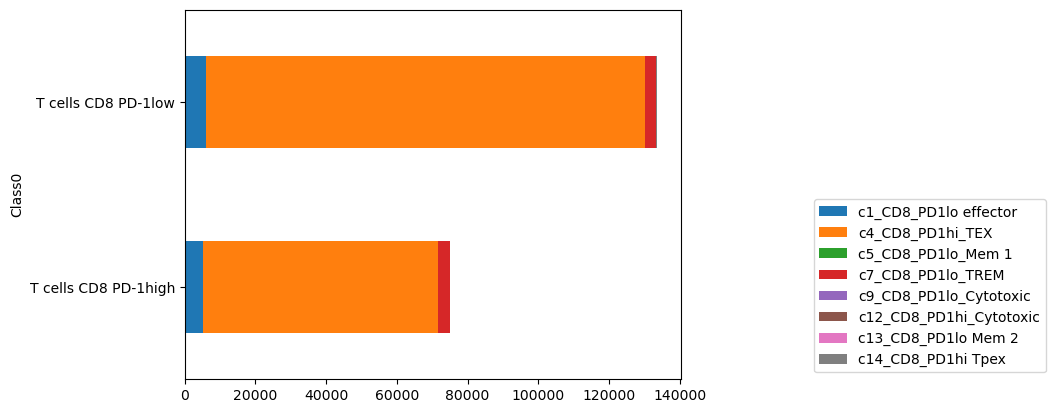

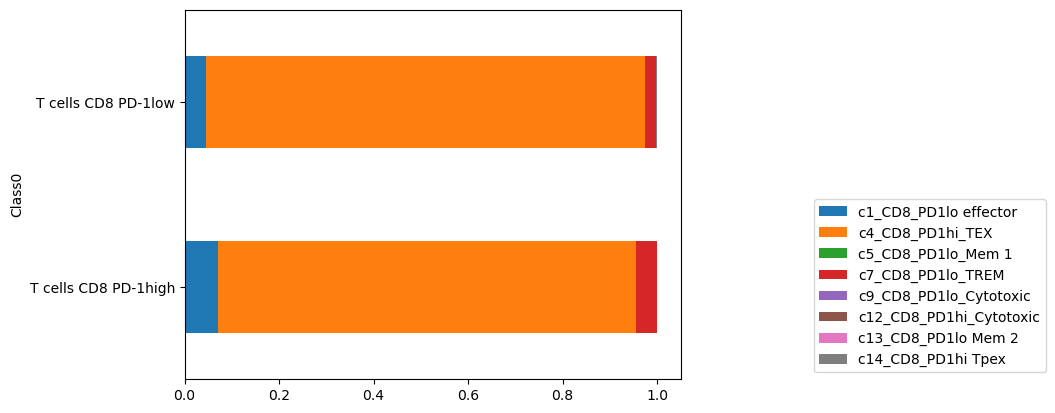

In [271]:
adata_compare.var_names = (
    sc_adata_ref.var_names
)  # we need  to have same variable labels

adata_compare.uns["Cluster label_colors"] = sc_adata_ref.uns[
    "Cluster label_colors"
]  # share colors

scp.tl.ingest(adata_compare, sc_adata_ref, obs="Cluster label")

scp.pl.umap(adata_compare, color=["Cluster label", "Class0"], wspace=0.5)

color_dict = {
    "c1_CD8_PD1lo effector": "#1f77b4",
    "c4_CD8_PD1hi_TEX": "#ff7f0e",
    "c5_CD8_PD1lo_Mem 1": "#2ca02c",
    "c7_CD8_PD1lo_TREM": "#d62728",
    "c9_CD8_PD1lo_Cytotoxic": "#9467bd",
    "c12_CD8_PD1hi_Cytotoxic": "#8c564b",
    "c13_CD8_PD1lo Mem 2": "#e377c2",
    "c14_CD8_PD1hi Tpex": "#7f7f7f",
}

count_df_ = (
    adata_compare.obs.value_counts(["Class0", "Cluster label"])
    .reset_index()
    .pivot(index="Class0", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True, color=color_dict)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True, color=color_dict)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

Accuracy: 0.362516430483464
F1-high: 0.4996611343715172
F1-low: 0.12179809141135108
F1-avg: 0.31072961289143414
              precision    recall  f1-score   support

    PD1-high       0.35      0.89      0.50     74908
     PD1-low       0.52      0.07      0.12    133546

    accuracy                           0.36    208454
   macro avg       0.43      0.48      0.31    208454
weighted avg       0.46      0.36      0.26    208454



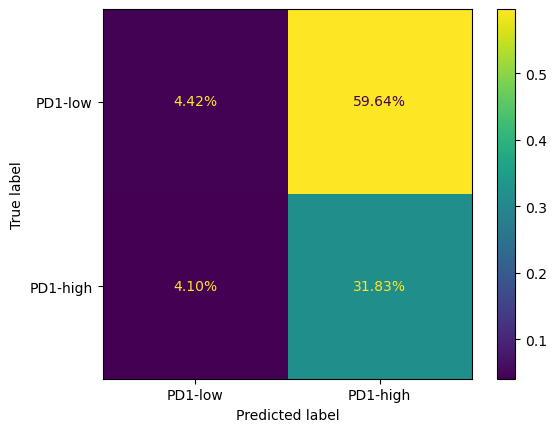

In [272]:
adata_labeled = adata_compare[adata_compare.obs["Cluster label"].notnull()]

predicted_pd1_levels = ["PD1hi" in x for x in adata_labeled.obs["Cluster label"]]
predicted_pd1_levels = ["PD1-high" if x else "PD1-low" for x in predicted_pd1_levels]
true_pd1_levels = adata_labeled.obs["Class0"] == "T cells CD8 PD-1high"
true_pd1_levels = ["PD1-high" if x else "PD1-low" for x in true_pd1_levels]


accuracy = accuracy_score(true_pd1_levels, predicted_pd1_levels)
f1_hi = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-high")
f1_low = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-low")

print("Accuracy:", accuracy)
print("F1-high:", f1_hi)
print("F1-low:", f1_low)
print("F1-avg:", (f1_low + f1_hi) / 2)


labels = ["PD1-low", "PD1-high"]

print(classification_report(true_pd1_levels, predicted_pd1_levels))

cm = confusion_matrix(true_pd1_levels, predicted_pd1_levels, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm / np.sum(cm), display_labels=labels)
disp.plot(values_format=".2%")